In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import KBinsDiscretizer

import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
from pgmpy.models import DiscreteBayesianNetwork

from pgmpy.estimators import (
    GES, HillClimbSearch, TreeSearch,    # structure learners
    BIC, BayesianEstimator                  # scores & parameter estimators
)

from pgmpy.inference import VariableElimination

## Data loading and inspection


In [82]:
df = pd.read_csv("CVD_cleaned.csv")
print(f'dfset contains {df.shape[0]} rows and {df.shape[1]} columns')
df.head()

dfset contains 308854 rows and 19 columns


,General_Health,Checkup,Exercise,Heart_Disease,Skin_Cancer,Other_Cancer,Depression,Diabetes,Arthritis,Sex,Age_Category,Height_(cm),Weight_(kg),BMI,Smoking_History,Alcohol_Consumption,Fruit_Consumption,Green_Vegetables_Consumption,FriedPotato_Consumption
0,Poor,Within the past 2 years,No,No,No,No,No,No,Yes,Female,70-74,150.0,32.66,14.54,Yes,0.0,30.0,16.0,12.0
1,Very Good,Within the past year,No,Yes,No,No,No,Yes,No,Female,70-74,165.0,77.11,28.29,No,0.0,30.0,0.0,4.0
2,Very Good,Within the past year,Yes,No,No,No,No,Yes,No,Female,60-64,163.0,88.45,33.47,No,4.0,12.0,3.0,16.0
3,Poor,Within the past year,Yes,Yes,No,No,No,Yes,No,Male,75-79,180.0,93.44,28.73,No,0.0,30.0,30.0,8.0
4,Good,Within the past year,No,No,No,No,No,No,No,Male,80+,191.0,88.45,24.37,Yes,0.0,8.0,4.0,0.0


In [83]:
df.drop(columns=['General_Health', 'Checkup'], inplace=True)

# Create a new column 'Cancer' based on 'Skin_Cancer' and 'Other_Cancer'
df['Cancer'] = df.apply(lambda row: 'Yes' if row['Skin_Cancer'] == 'Yes' or row['Other_Cancer'] == 'Yes' else 'No', axis=1)
df.drop(columns=['Skin_Cancer', 'Other_Cancer'], inplace=True)

# Modify the 'Diabetes' column to have only 'Yes' or 'No'
df['Diabetes'] = df['Diabetes'].apply(lambda x: 'Yes' if x == 'Yes' else 'No')

print("After the changes, there are " + str(len(df.columns)) + " columns: ")
df.columns

After the changes, there are 16 columns: 


Index(['Exercise', 'Heart_Disease', 'Depression', 'Diabetes', 'Arthritis',
       'Sex', 'Age_Category', 'Height_(cm)', 'Weight_(kg)', 'BMI',
       'Smoking_History', 'Alcohol_Consumption', 'Fruit_Consumption',
       'Green_Vegetables_Consumption', 'FriedPotato_Consumption', 'Cancer'],
      dtype='object')

In [84]:
for col in df.columns:
    uniques = np.sort(df[col].unique())
    print(f"{col}: lowest value = {uniques[0]}, largest value = {uniques[-1]}")

Exercise: lowest value = No, largest value = Yes
Heart_Disease: lowest value = No, largest value = Yes
Depression: lowest value = No, largest value = Yes
Diabetes: lowest value = No, largest value = Yes
Arthritis: lowest value = No, largest value = Yes
Sex: lowest value = Female, largest value = Male
Age_Category: lowest value = 18-24, largest value = 80+
Height_(cm): lowest value = 91.0, largest value = 241.0
Weight_(kg): lowest value = 24.95, largest value = 293.02
BMI: lowest value = 12.02, largest value = 99.33
Smoking_History: lowest value = No, largest value = Yes
Alcohol_Consumption: lowest value = 0.0, largest value = 30.0
Fruit_Consumption: lowest value = 0.0, largest value = 120.0
Green_Vegetables_Consumption: lowest value = 0.0, largest value = 128.0
FriedPotato_Consumption: lowest value = 0.0, largest value = 128.0
Cancer: lowest value = No, largest value = Yes


## Dataset Columns Descriptions

Dataset link: [Dataset](https://www.kaggle.com/datasets/alphiree/cardiovascular-diseases-risk-prediction-dataset)

- **Exercise**: Indicates whether the individual participates in physical activity (e.g. "Yes" or "No").

- **Heart_Disease**: Reports if the individual has been diagnosed with heart disease.

- **Depression**: Indicates whether the individual has been diagnosed with depression.

- **Diabetes**: Reports the diabetes status. It may include simple "Yes"/"No" values or more detailed categories.

- **Arthritis**: Indicates if the individual has arthritis.

- **Sex**: The gender of the individual (e.g. "Male" or "Female").

- **Age_Category**: Categorical representation of the age range of the individual (e.g. "70-74", "80+").

- **Height_(cm)**: The height of the individual measured in centimeters.

- **Weight_(kg)**: The weight of the individual measured in kilograms.

- **BMI**: Body Mass Index calculated from height and weight, providing an estimate of body fat.

- **Smoking_History**: Indicates whether the individual has a history of smoking.

- **Alcohol_Consumption**: A measure of the individual's alcohol intake (number of alcoholic drinks each month); it is later discretized into categories (e.g. "Low" or "High").

- **Fruit_Consumption**: A measure of the amount of fruit consumed (number of fruits each month), later categorized (e.g. "Low" or "High").

- **Green_Vegetables_Consumption**: Indicates the consumption level of green vegetables (number of meals per month), categorized for analysis.

- **FriedPotato_Consumption**: Reports the consumption level of fried potatoes (number of meals per month), discretized into categories.

- **Cancer**: A derived column that indicates the occurrence of any cancer; it is set to "Yes" if either skin cancer or another form of cancer was reported, and "No" otherwise.


## Discretization of continuous variables


The cut-off numbers between the categories were chosen based on research carried out on the recommendations of international health bodies.

In [85]:
# Columns to be discretized using KBinsDiscretizer
continuous_columns = ['Height_(cm)', 'Weight_(kg)']

discretizer = KBinsDiscretizer(n_bins=4, encode='ordinal', strategy='quantile')
df_disc = df.copy()

df_disc[continuous_columns] = discretizer.fit_transform(df[continuous_columns])

# Discretization rules for other numeric columns
discretization_rules = {
    'BMI': {
        'bins': [-float('inf'), 18.5, 24.9, 29.9, float('inf')],
        'labels': ['Underweight', 'Normal weight', 'Overweight', 'Obese']
    },
    'Alcohol_Consumption': {
        'bins': [-float('inf'), 10.0, float('inf')],
        'labels': ['Low', 'High']
    },
    'Fruit_Consumption': {
        'bins': [-float('inf'), 50.0, float('inf')],
        'labels': ['Low', 'High']
    },
    'Green_Vegetables_Consumption': {
        'bins': [-float('inf'), 30.0, float('inf')],
        'labels': ['Low', 'High']
    },
    'FriedPotato_Consumption': {
        'bins': [-float('inf'), 10.0, float('inf')],
        'labels': ['Low', 'High']
    }
}

for column, rule in discretization_rules.items():
    df_disc[column] = pd.cut(df[column], bins=rule['bins'], labels=rule['labels'])

# Display distribution of discretized columns
columns_to_display = continuous_columns + list(discretization_rules.keys())

for column in columns_to_display:
    print(f"Distribution of '{column}':")
    print(df_disc[column].value_counts())
    print("\n")

Distribution of 'Height_(cm)':
Height_(cm)
3.0    96973
1.0    76605
2.0    70514
0.0    64762
Name: count, dtype: int64


Distribution of 'Weight_(kg)':
Weight_(kg)
1.0    83550
3.0    80225
2.0    76182
0.0    68897
Name: count, dtype: int64


Distribution of 'BMI':
BMI
Overweight       109866
Obese            106738
Normal weight     87706
Underweight        4544
Name: count, dtype: int64


Distribution of 'Alcohol_Consumption':
Alcohol_Consumption
Low     257101
High     51753
Name: count, dtype: int64


Distribution of 'Fruit_Consumption':
Fruit_Consumption
Low     240512
High     68342
Name: count, dtype: int64


Distribution of 'Green_Vegetables_Consumption':
Green_Vegetables_Consumption
Low     295832
High     13022
Name: count, dtype: int64


Distribution of 'FriedPotato_Consumption':
FriedPotato_Consumption
Low     254460
High     54394
Name: count, dtype: int64




## Exploration of the correlation heatmap

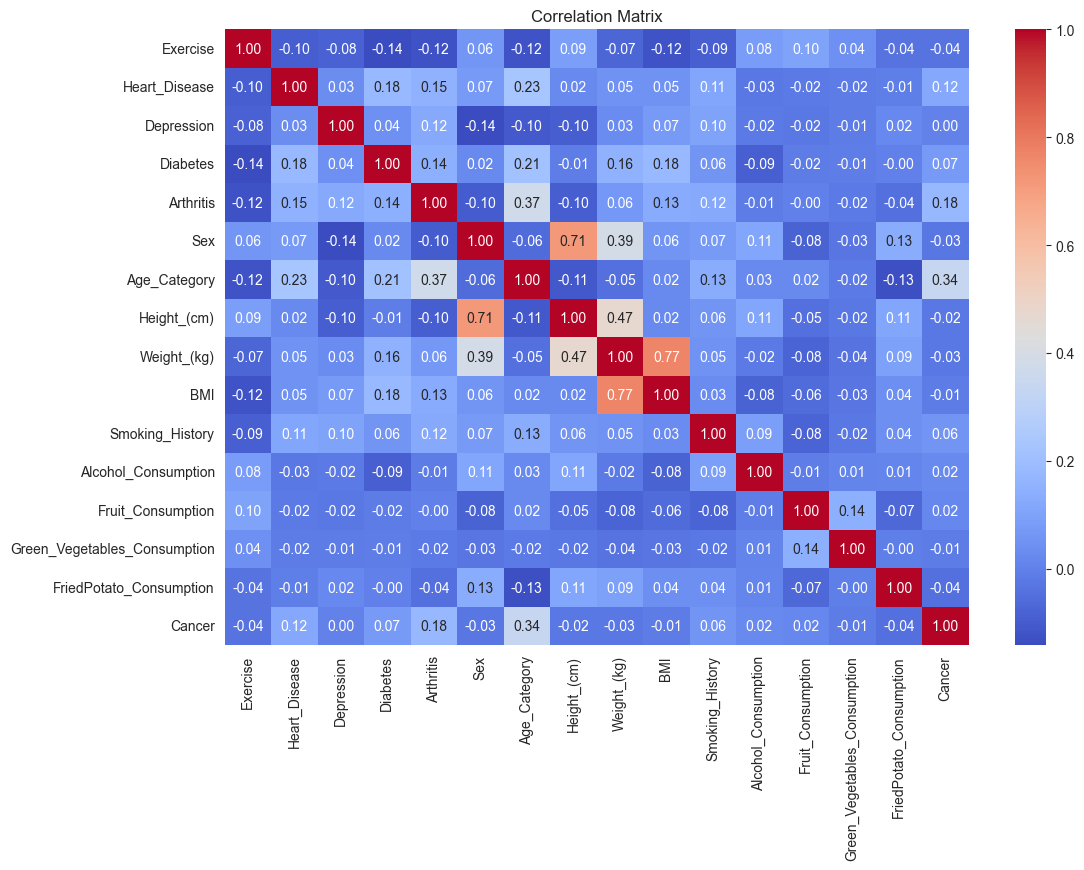

In [86]:
df_temp = df_disc.copy()

# Convert categorical variables to numerical codes
# This is necessary for correlation calculation
for col in df_temp.select_dtypes(include=['category', 'object']).columns:
    df_temp[col] = df_temp[col].astype('category').cat.codes

# Calculate and show the correlation matrix
plt.figure(figsize=(12, 8))
sns.heatmap(df_temp.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

## Definition of a custom network structure

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}


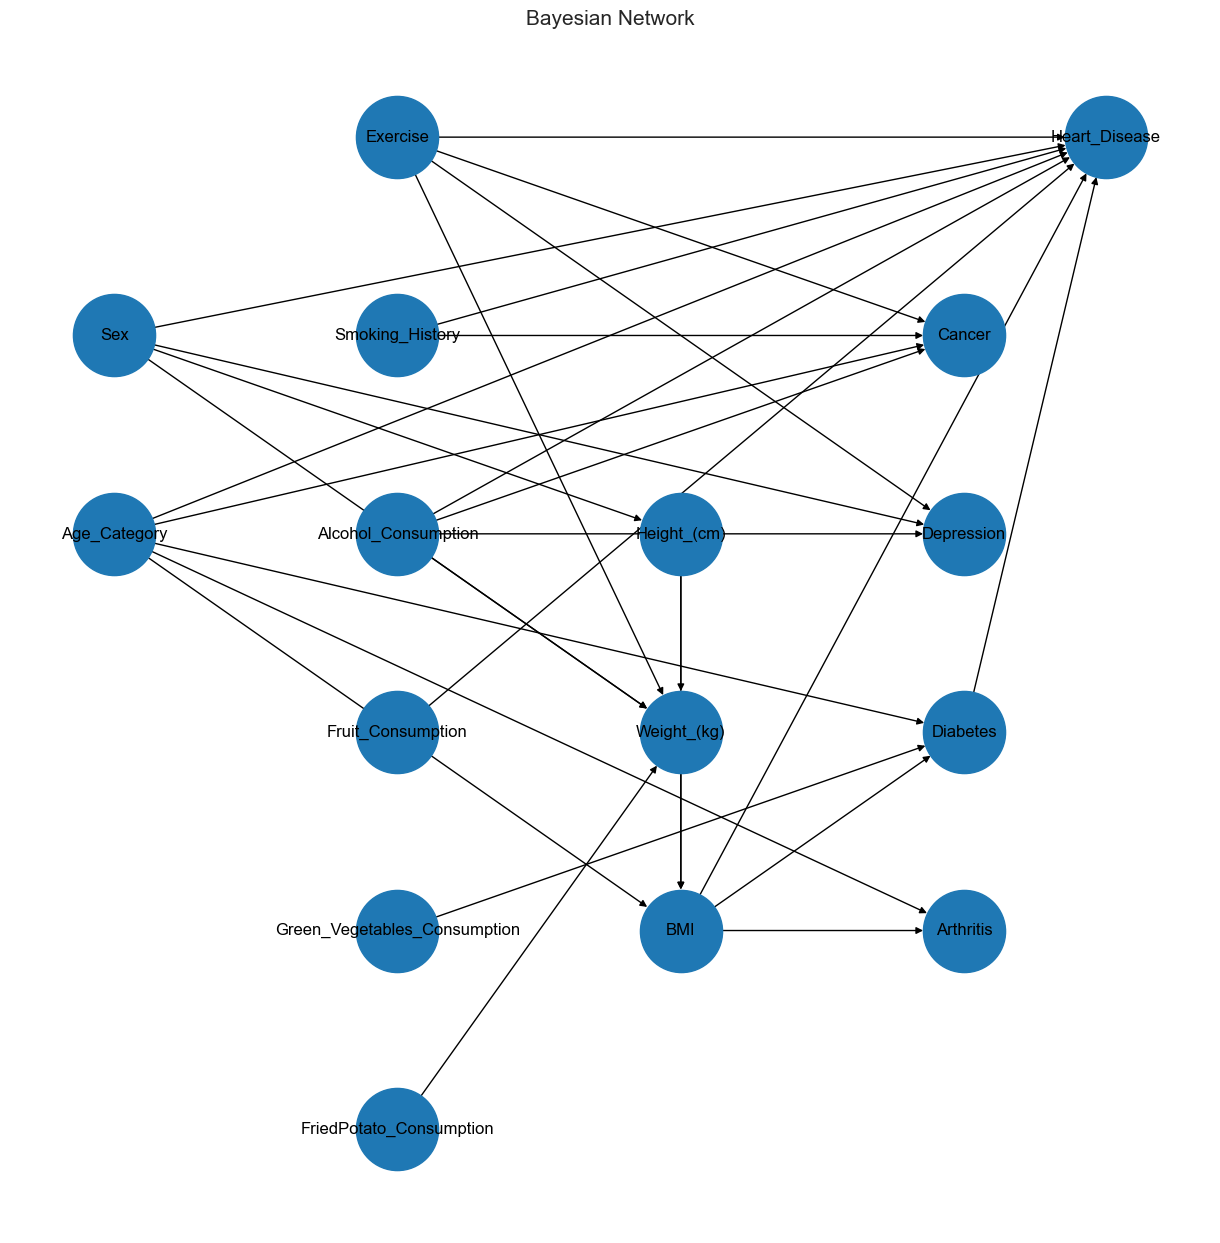

In [87]:
custom_model = DiscreteBayesianNetwork([
    ('Height_(cm)', 'Weight_(kg)'),  
    ('Height_(cm)', 'BMI'),  
    ('Weight_(kg)', 'BMI'),

    ('Sex', 'Heart_Disease'),  # Sex influences biological risk for heart disease
    ('Sex', 'Depression'),  # Sex differences in depression prevalence (e.g. women have higher rates)
    ('Sex', 'Weight_(kg)'),  
    ('Sex', 'Height_(cm)'),  

    ('Age_Category', 'Heart_Disease'),  # Heart disease risk increases with age
    ('Age_Category', 'Diabetes'),  # Age is a known risk factor for diabetes
    ('Age_Category', 'Arthritis'),  # Arthritis prevalence increases with age
    ('Age_Category', 'BMI'),  # BMI may increase or fluctuate with age due to metabolic changes
    ('Age_Category', 'Cancer'),  # Many cancers are more prevalent with age

    ('Smoking_History', 'Heart_Disease'),  
    ('Smoking_History', 'Cancer'),  

    ('Alcohol_Consumption', 'Heart_Disease'),  # Excessive alcohol can raise blood pressure and harm the heart
    ('Alcohol_Consumption', 'Cancer'),  # Alcohol consumption increases cancer risk (e.g. liver cancer)
    ('Alcohol_Consumption', 'Depression'),  # Alcohol use is associated with higher depression risk
    ('Alcohol_Consumption', 'Weight_(kg)'),  # Alcohol adds extra calories, potentially increasing weight

    ('Fruit_Consumption', 'Heart_Disease'),  # Diets rich in fruit are linked to lower heart disease risk

    ('Green_Vegetables_Consumption', 'Diabetes'),  # Vegetables can improve insulin sensitivity and reduce diabetes risk

    ('FriedPotato_Consumption', 'Weight_(kg)'),  

    ('Exercise', 'Heart_Disease'),  
    ('Exercise', 'Depression'),  # Exercise is known to improve mental health and reduce depression
    ('Exercise', 'Weight_(kg)'),  
    ('Exercise', 'Cancer'),  # Physical activity lowers risk of several cancers

    ('BMI', 'Heart_Disease'),  
    ('BMI', 'Diabetes'),  
    ('BMI', 'Arthritis'),  # Excess body weight adds stress on joints, increasing arthritis risk

    ('Diabetes', 'Heart_Disease'),  # Diabetes significantly increases cardiovascular disease risk
])

pos = {
    # Column 1: Demographics
    'Sex': (0, 3),
    'Age_Category': (0, 2),

    # Column 2: Lifestyle
    'Exercise': (2, 4),
    'Smoking_History': (2, 3),
    'Alcohol_Consumption': (2, 2),
    'Fruit_Consumption': (2, 1),
    'Green_Vegetables_Consumption': (2, 0),
    'FriedPotato_Consumption': (2, -1),

    # Column 3: Health Metrics
    'Height_(cm)': (4, 2),
    'Weight_(kg)': (4, 1),
    'BMI': (4, 0),

    # Column 4: Health Conditions
    'Heart_Disease': (7, 4),
    'Cancer': (6, 3),
    'Depression': (6, 2),
    'Diabetes': (6, 1),
    'Arthritis': (6, 0),
}

custom_model.fit(df_disc, estimator=BayesianEstimator)

# Create a directed graph from the Bayesian model
plt.figure(figsize=(12, 12))
G = nx.DiGraph(custom_model.edges())
nx.draw(G, pos, with_labels=True, node_size=3500)

plt.title("Bayesian Network", fontsize=15)
plt.axis("off")
plt.show()

# Automatic Structure-Learning Algorithms

We decided to use also three standard algorithms provided by **pgmpy**:

| Algorithm | Family | Core idea | When it works best |
|-----------|--------|-----------|--------------------|
| **Chow–Liu Tree** | Mutual-information | Computes pairwise mutual information, builds a maximum-spanning tree, and orients edges away from an arbitrary root. Produces the *optimal* tree-structured BN in likelihood/KL sense. | Large numbers of variables when a tree approximation is acceptable or required. |
| **Hill-Climb Search (HC)** | Score-based | Starts from an initial DAG (empty by default) and iteratively applies the single edge operation that maximises the score until no improvement is possible. Simpler than GES but may get trapped in local optima sooner. | Small–to-medium data sets; good baseline for score-based learning. |
| **Greedy Equivalence Search (GES)** | Score-based | Greedily adds, deletes or reverses edges while staying inside an *equivalence class* of DAGs. At each step it picks the move giving the largest improvement in a chosen score (here: BIC). | Medium–large discrete data sets where the true graph is moderately sparse. |



After designing the structures, we subsequently estimate the conditional-probability tables (CPDs) with **BayesianEstimator** (Dirichlet priors) and perform inference with **VariableElimination**.


## Chow-Liu Tree

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
Building tree: 100%|██████████| 120/120.0 [00:01<00:00, 80.35it/s]
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}


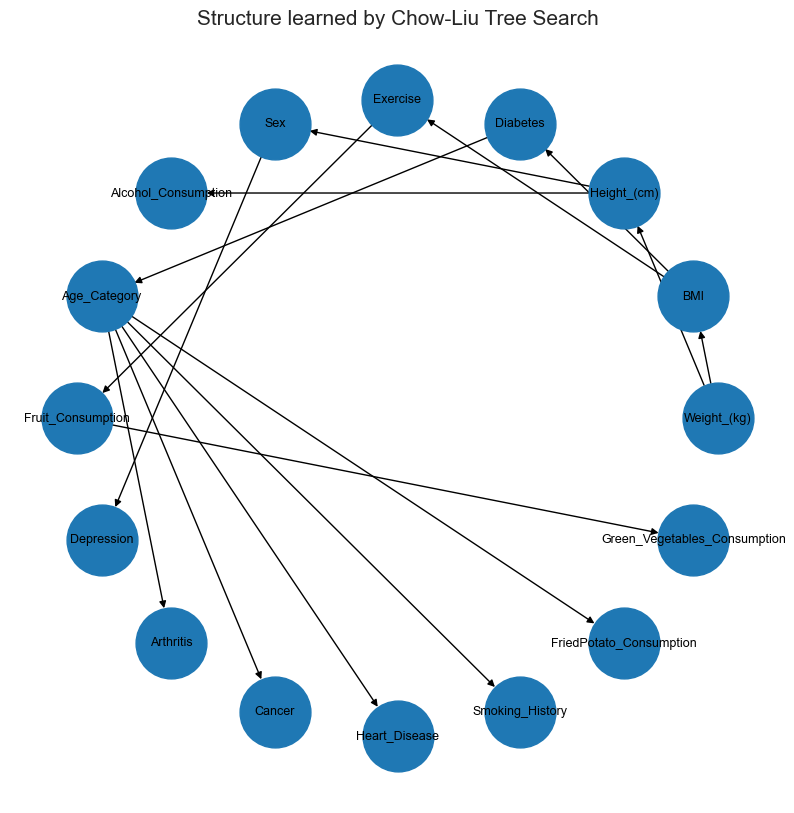

In [88]:
ts = TreeSearch(df_disc, root_node=None)     # Automatically select the root node
dag_cl = ts.estimate()

cl_model = DiscreteBayesianNetwork(dag_cl.edges())
cl_model.fit(df_disc, estimator=BayesianEstimator)

plt.figure(figsize=(10, 10))
pos = nx.circular_layout(cl_model)                     
nx.draw_networkx(cl_model, pos=pos,
                 node_size=2600, font_size=9,
                 arrows=True, arrowstyle='-|>')
plt.title("Structure learned by Chow-Liu Tree Search", fontsize=15)
plt.axis("off")
plt.show()

## Hill-Climb Search


INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'E

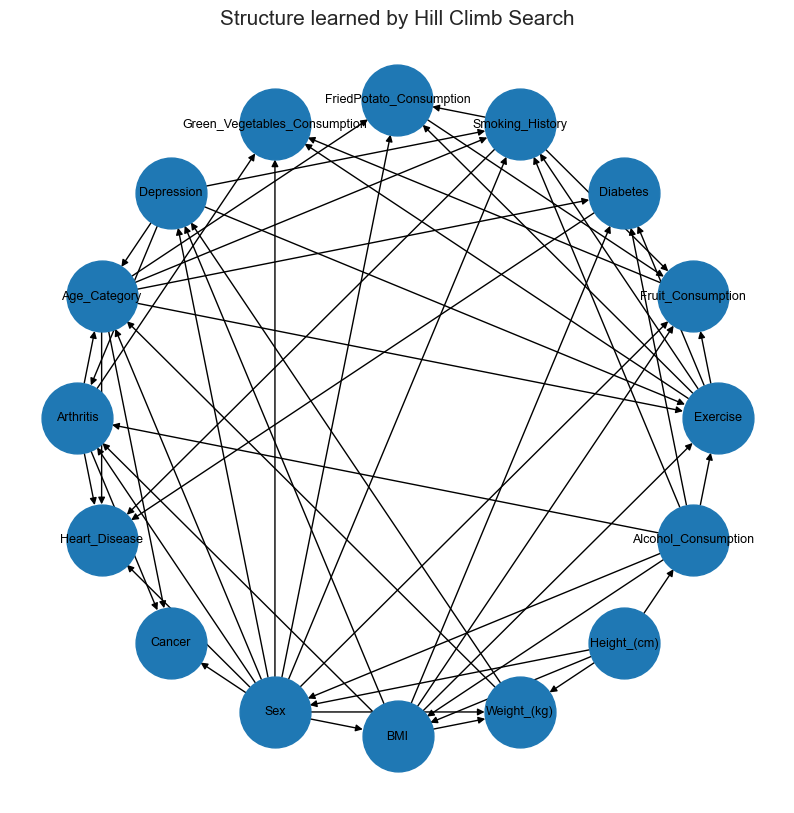

In [89]:
hc = HillClimbSearch(df_disc)                           
dag_hc = hc.estimate(scoring_method=BIC(df_disc))   
hc_model = DiscreteBayesianNetwork(dag_hc.edges())
hc_model.fit(df_disc, estimator=BayesianEstimator)

plt.figure(figsize=(10, 10))
pos = nx.circular_layout(hc_model)                     
nx.draw_networkx(hc_model, pos=pos,
                 node_size=2600, font_size=9,
                 arrows=True, arrowstyle='-|>')
plt.title("Structure learned by Hill Climb Search", fontsize=15)
plt.axis("off")
plt.show()

INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'Exercise': 'C', 'Heart_Disease': 'C', 'Depression': 'C', 'Diabetes': 'C', 'Arthritis': 'C', 'Sex': 'C', 'Age_Category': 'C', 'Height_(cm)': 'N', 'Weight_(kg)': 'N', 'BMI': 'O', 'Smoking_History': 'C', 'Alcohol_Consumption': 'O', 'Fruit_Consumption': 'O', 'Green_Vegetables_Consumption': 'O', 'FriedPotato_Consumption': 'O', 'Cancer': 'C'}
INFO:pgmpy: Datatype (N=numerical, C=Categorical Unordered, O=Categorical Ordered) inferred from data: 
 {'E

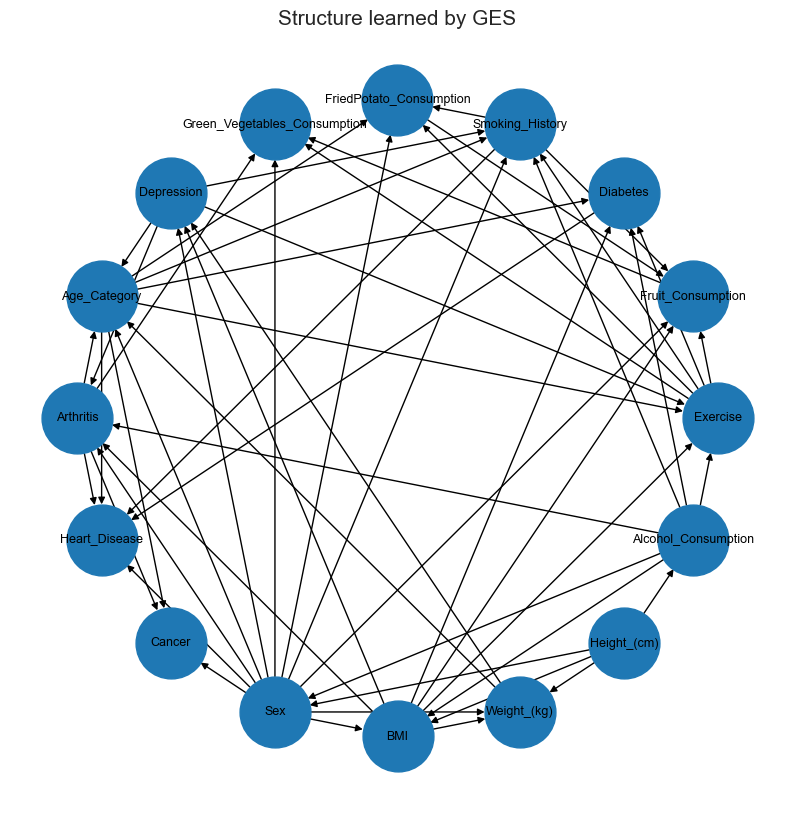

In [90]:
ges = GES(df_disc)                                      
dag_ges = ges.estimate(scoring_method=BIC(df_disc))     
                                                       
ges_model = DiscreteBayesianNetwork(dag_ges.edges())    
ges_model.fit(df_disc, estimator=BayesianEstimator)     


plt.figure(figsize=(10, 10))
pos = nx.circular_layout(ges_model)                     
nx.draw_networkx(ges_model, pos=pos,
                 node_size=2600, font_size=9,
                 arrows=True, arrowstyle='-|>')
plt.title("Structure learned by GES", fontsize=15)
plt.axis("off")
plt.show()

# Questions

In [91]:
# Create inference objects for the models
infer_custom = VariableElimination(custom_model)
infer_tree = VariableElimination(cl_model)
infer_hc = VariableElimination(hc_model)
infer_ges = VariableElimination(ges_model)

# Define the query function
def query_func(target: str, evid_a: dict, evid_b: dict):
    """
    Compare two evidence scenarios (Scenario A vs Scenario B) across the
    four Bayesian networks that have already been trained in the
    notebook—namely ``custom_model``, ``tree_model``, ``hc_model`` and ``ges_model``
    and display a paired bar chart of the probabilities of the target
    variable being in the *positive* state (e.g. *Yes*).

    Parameters
    ----------
    target : str
        The name of the target variable (for example ``"Cancer"``). The
        function assumes that the *positive* state of this binary
        variable (e.g. *Yes*) is located at index 1 in the CPD array.
    evid_a : dict
        Dictionary of evidences for Scenario A in the form
        ``{"Variable": "State", ...}``.
    evid_b : dict
        Dictionary of evidences for Scenario B in the same format.

    """

    inferences = [infer_custom, infer_tree, infer_hc, infer_ges]
    labels = ["Domain-driven", "Chow-Liu", "Hill-Climb", "GES"]

    print("Scenario A Evidence:", evid_a)
    print("Scenario B Evidence:", evid_b)

    # Compute P(target = Yes) for both scenarios in each model
    p_a, p_b = [], []
    for infer in inferences:
        q_a = infer.query([target], evidence=evid_a)
        q_b = infer.query([target], evidence=evid_b)

        # index 1 corresponds to the “Yes” state in a binary variable
        p_a.append(float(q_a.values[1]))
        p_b.append(float(q_b.values[1]))

    sns.set_style("whitegrid")
    width = 0.35                      
    x = range(4)                      

    plt.figure(figsize=(8, 5))

    plt.bar(
        [i - width / 2 for i in x],
        p_a,
        width=width,
        label="Scenario A",
        edgecolor="black"
    )

    plt.bar(
        [i + width / 2 for i in x],
        p_b,
        width=width,
        label="Scenario B",
        edgecolor="black",
        hatch="//"
    )

    plt.xticks(x, labels, fontsize=12)
    plt.ylabel(f"P({target} = Yes)", fontsize=12)
    plt.title(f"{target}: Scenario A vs B", fontsize=14, pad=10)
    plt.ylim(0, 1)
    plt.legend()
    plt.tight_layout()
    plt.show()

def query_func_all_states(target: str, evid_a: dict, evid_b: dict):
    """
    Compare two evidence scenarios (Scenario A vs Scenario B) across the
    four Bayesian networks and plot the full distribution of the target variable.

    Parameters
    ----------
    target : str
        The name of the target variable.
    evid_a : dict
        Evidence for Scenario A.
    evid_b : dict
        Evidence for Scenario B.
    """

    models = [custom_model, cl_model, hc_model, ges_model]
    inferences = [VariableElimination(m) for m in models]
    model_labels = ["Domain-driven", "Chow-Liu", "Hill-Climb", "GES"]

    print("Scenario A Evidence:", evid_a)
    print("Scenario B Evidence:", evid_b)

    # Get all possible states for the target variable from the first model
    target_states = models[0].get_cpds(target).state_names[target]
    num_states = len(target_states)

    # Create lists of probabilities for each scenario and model
    probs_a = [[] for _ in range(num_states)]
    probs_b = [[] for _ in range(num_states)]

    for infer in inferences:
        q_a = infer.query([target], evidence=evid_a)
        q_b = infer.query([target], evidence=evid_b)

        for i in range(num_states):
            probs_a[i].append(float(q_a.values[i]))
            probs_b[i].append(float(q_b.values[i]))

    # Plot
    sns.set_style("whitegrid")
    width = 0.35
    x = range(len(model_labels))

    for i, state in enumerate(target_states):
        plt.figure(figsize=(8, 5))
        plt.bar(
            [j - width / 2 for j in x],
            probs_a[i],
            width=width,
            label="Scenario A",
            edgecolor="black"
        )
        plt.bar(
            [j + width / 2 for j in x],
            probs_b[i],
            width=width,
            label="Scenario B",
            edgecolor="black",
            hatch="//"
        )
        plt.xticks(x, model_labels, fontsize=12)
        plt.ylabel(f"P({target} = {state})", fontsize=12)
        plt.title(f"{target} = {state}: Scenario A vs B", fontsize=14, pad=10)
        plt.ylim(0, 1)
        plt.legend()
        plt.tight_layout()
        plt.show()


## Query 1:
"What's the impact of smoking on cancer?"

Scenario A Evidence: {'Smoking_History': 'No', 'Exercise': 'Yes'}
Scenario B Evidence: {'Smoking_History': 'Yes', 'Exercise': 'No'}


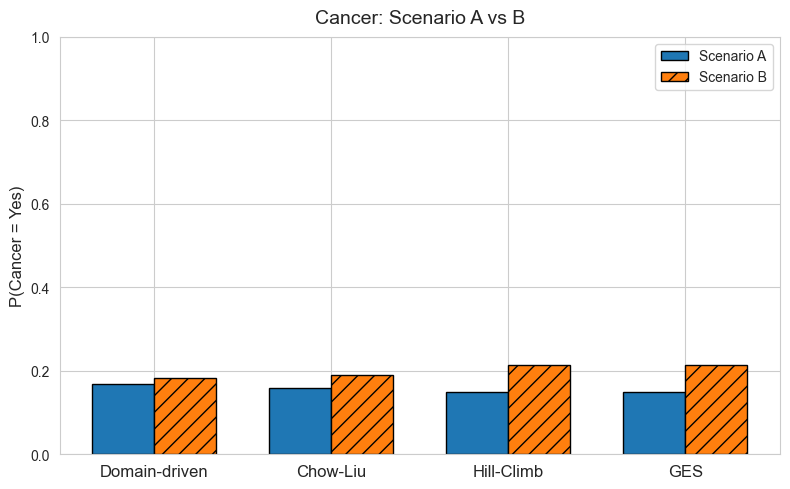

In [ ]:
scenario_A = {'Smoking_History': 'No', 'Exercise': 'Yes'}
scenario_B = {'Smoking_History': 'Yes', 'Exercise': 'No'}

query_func("Cancer", scenario_A, scenario_B)

- All networks estimate a higher probability of cancer in the smoker + sedentary scenario than in the non-smoker + physically active one. 

 

- The Tree and the custom networks give the most conservative figures, while the HC and GES networks are more severe. 

 

- The close convergence among models (bars with very similar profiles) indicates that the effect is robust to the choice of learning algorithm. 

## Query 2:
"What's the probability of developing a cardiac disease given that the patient is non smoker and athletic?"

In [ ]:
scenario_A = {'Smoking_History': 'No', 'Exercise': 'Yes'}
scenario_B = {'Smoking_History': 'Yes', 'Exercise': 'No'}

query_func("Heart_Disease", scenario_A, scenario_B)

- All four models agree that being sedentary and a smoker raises the probability of cancer compared to being athletic and a non-smoker.

- The lower difference in Chow–Liu likely comes from:
  - **Tree constraint.** A Chow–Liu tree has exactly *n – 1* edges and each node can have only one parent, so it cannot model multi-way interactions (e.g., smoking **plus** inactivity acting together).
  - **Pairwise mutual-information selection.** Chow–Liu chooses edges by maximizing **pairwise** mutual information. If *Depression* exhibits many small correlations rather than one strong one, no single edge stands out; the node then remains isolated or connected only through long, indirect paths, weakening any detectable effect.


## Query 3:
"What's the impact of different diseases on depression?"

Scenario A Evidence: {'Arthritis': 'Yes'}
Scenario B Evidence: {'Arthritis': 'No'}


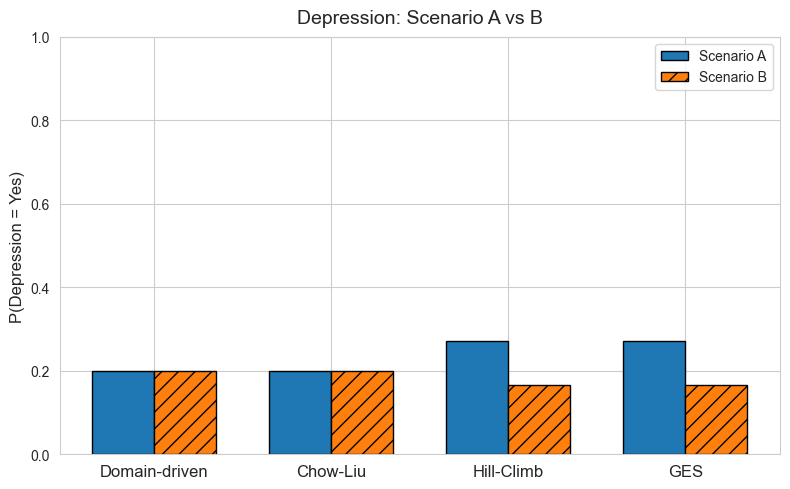

Scenario A Evidence: {'Diabetes': 'Yes'}
Scenario B Evidence: {'Diabetes': 'No'}


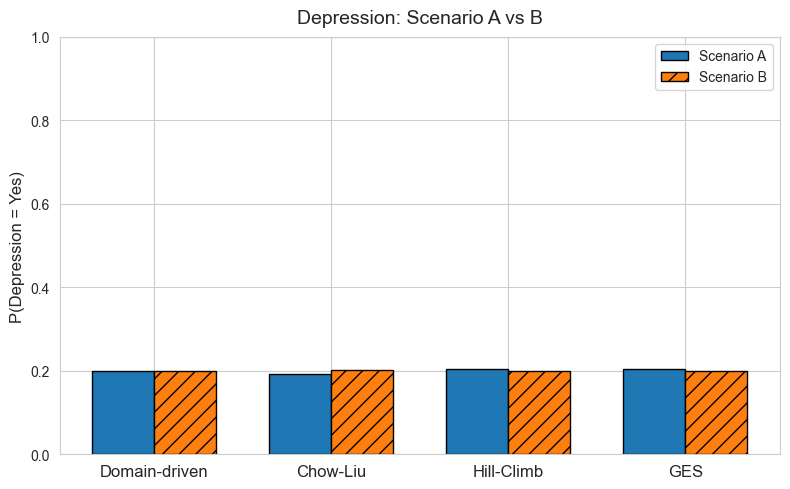

In [93]:
scenario_A = {'Arthritis': 'Yes'}
scenario_B = {'Arthritis': 'No'}
query_func("Depression", scenario_A, scenario_B)


scenario_A = {'Diabetes': 'Yes'}
scenario_B = {'Diabetes': 'No'}
query_func("Depression", scenario_A, scenario_B)

- **Arthritis vs. Depression.** Two of the four networks estimate a clear rise in the probability of depression for people with arthritis, while the Custom and Chow–Liu networks show virtually no change.

- **Diabetes vs. Depression.** In all four networks, the bars are very similar, indicating that diabetes status adds no detectable information about depression risk in this dataset.

- The Domain-driven model shows identical bars because in the custom network we designed, there is **no direct or indirect path** from **Arthritis** or **Diabetes** to **Depression**, so evidence on arthritis cannot influence the posterior of depression.

## Query 4:
"What is the combined effect of factors such as alcohol consumption, diet (fruit, vegetables, and fried potatoes) and physical activity on the probability of developing heart diseases?"

Scenario A Evidence: {'Exercise': 'Yes', 'Alcohol_Consumption': 'Low', 'Fruit_Consumption': 'High', 'Green_Vegetables_Consumption': 'High', 'FriedPotato_Consumption': 'Low', 'Smoking_History': 'No'}
Scenario B Evidence: {'Exercise': 'No', 'Alcohol_Consumption': 'High', 'Fruit_Consumption': 'Low', 'Green_Vegetables_Consumption': 'Low', 'FriedPotato_Consumption': 'High', 'Smoking_History': 'Yes'}


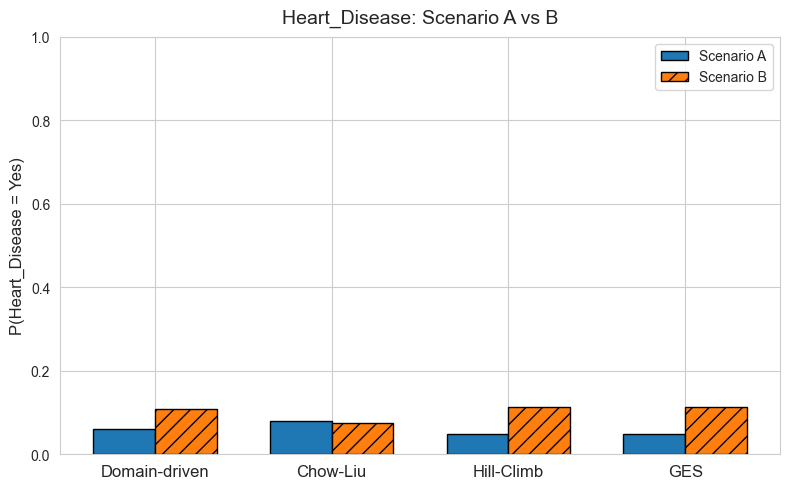

In [95]:
scenario_A = {
    'Exercise': 'Yes',
    'Alcohol_Consumption': 'Low',
    'Fruit_Consumption': 'High',
    'Green_Vegetables_Consumption': 'High',
    'FriedPotato_Consumption': 'Low',
    'Smoking_History': 'No'
}
scenario_B = {
    'Exercise': 'No',
    'Alcohol_Consumption': 'High',
    'Fruit_Consumption': 'Low',
    'Green_Vegetables_Consumption': 'Low',
    'FriedPotato_Consumption': 'High',
    'Smoking_History': 'Yes'
}

query_func("Heart_Disease", scenario_A, scenario_B)

- All networks but Chow-Liu predict an increase in heart disease risk for an unhealthy lifestyle.

- The Tree-based method shows two very similar bars, showing a slightly lower probability under the unhealthy scenario. This may point to already explained reasons about decision trees.

## Query 5
"Does a person's sex influence the risk of developing heart disease?"

Scenario A Evidence: {'Sex': 'Male'}
Scenario B Evidence: {'Sex': 'Female'}


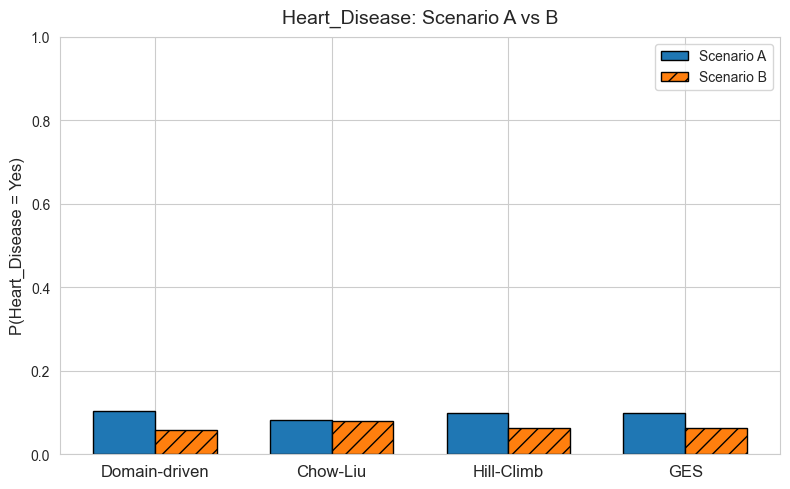

In [96]:
scenario_A = {'Sex': 'Male'}
scenario_B = {'Sex': 'Female'}

query_func("Heart_Disease", scenario_A, scenario_B)

- All networks but Chow Liu agree: males carry a higher risk on developing heart diseases.



# Query 6
"How age influences diabetes probability"

Scenario A Evidence: {'Diabetes': 'Yes'}
Scenario B Evidence: {'Diabetes': 'No'}


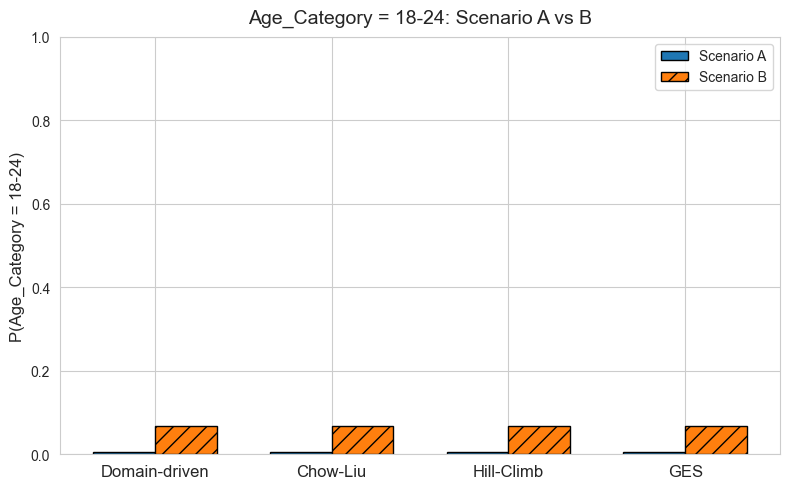

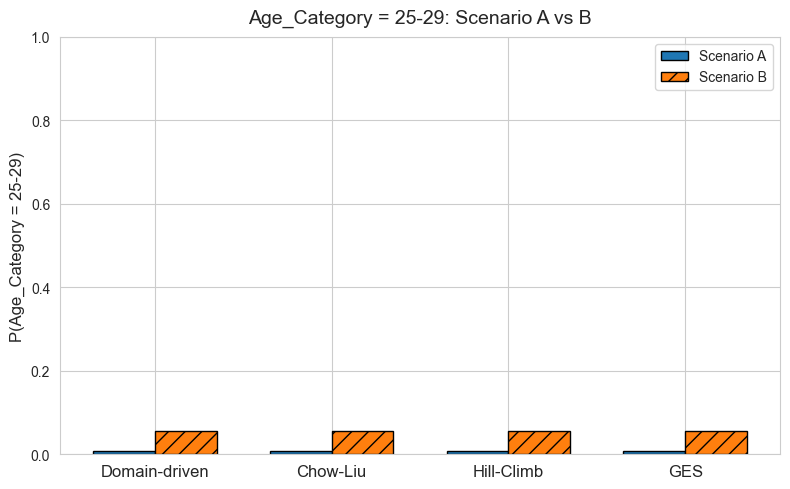

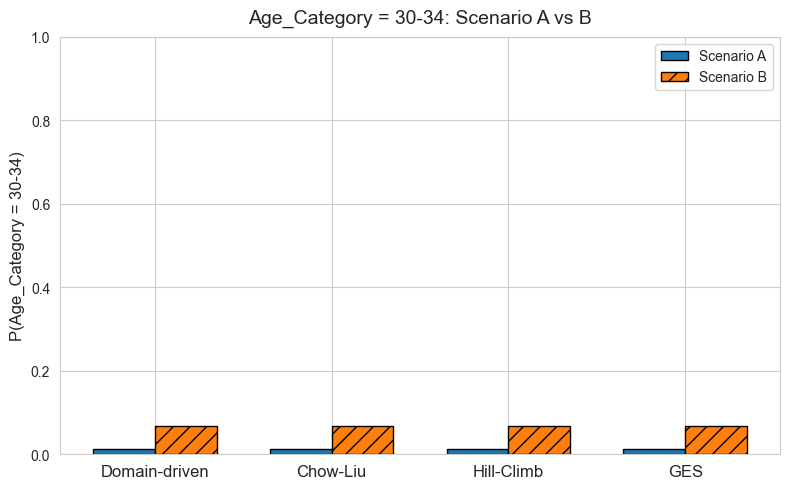

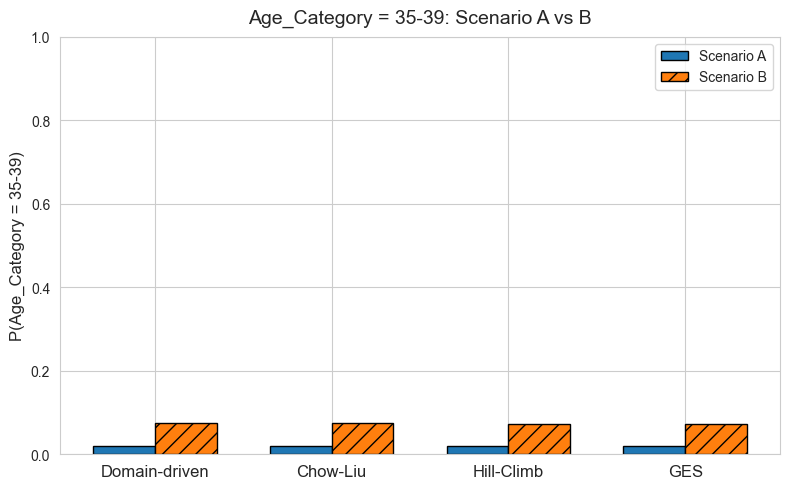

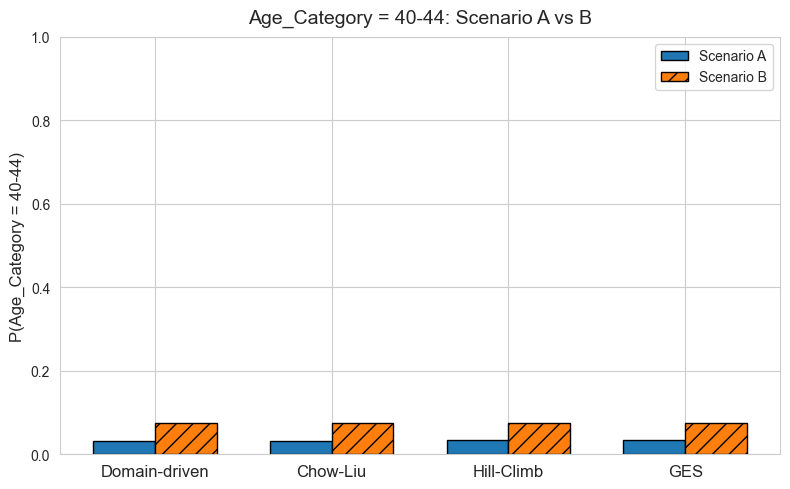

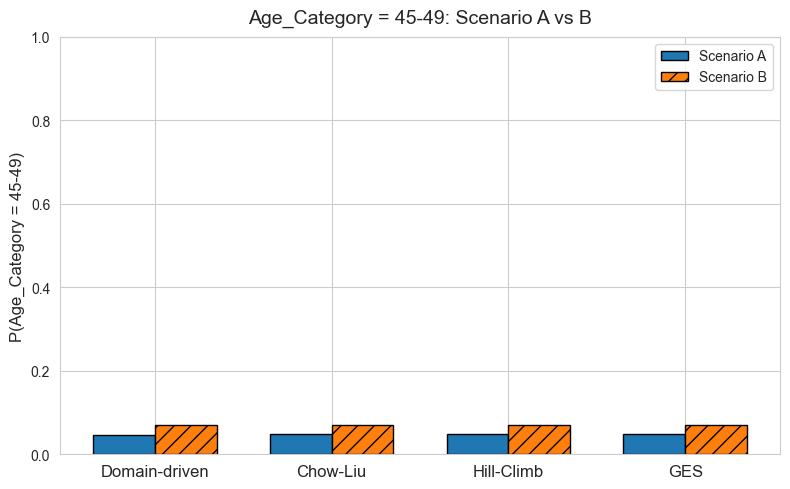

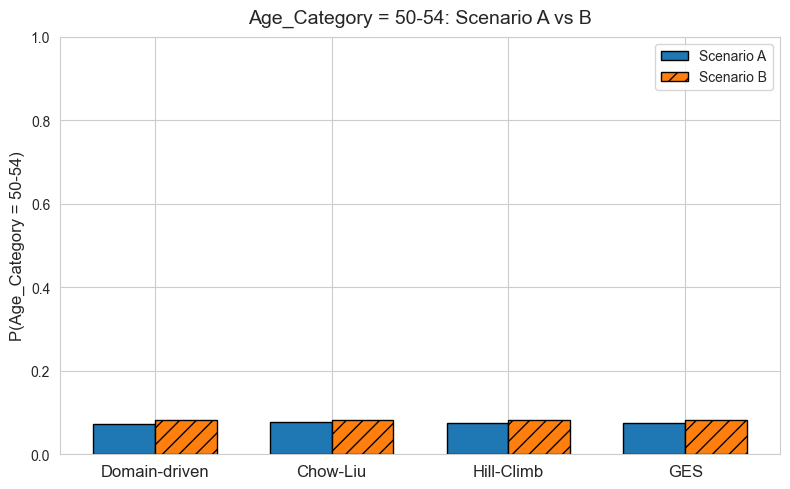

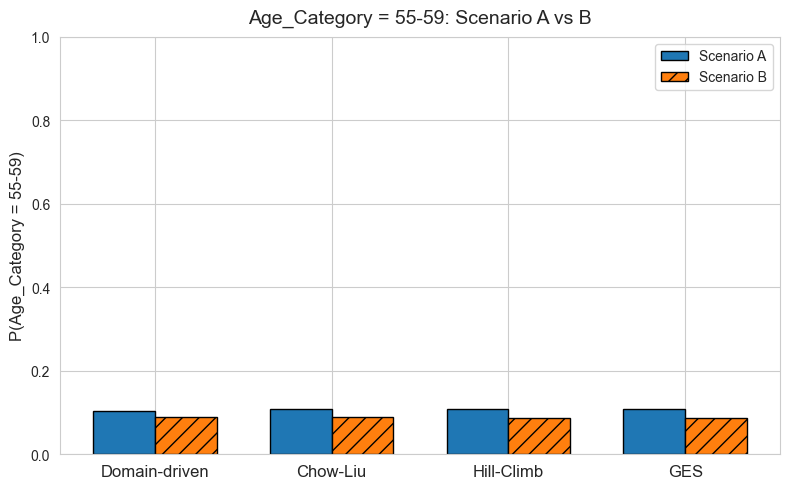

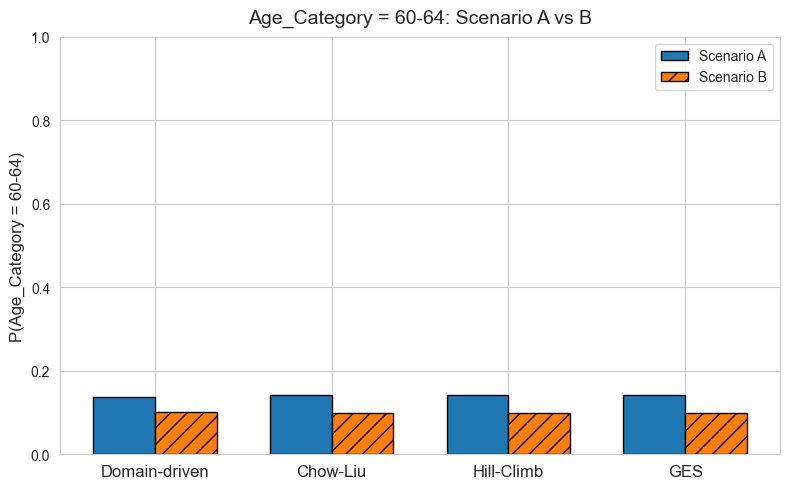

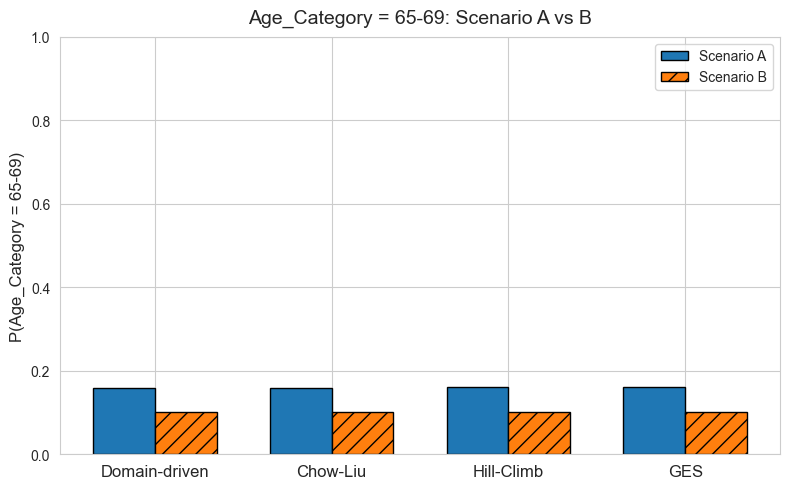

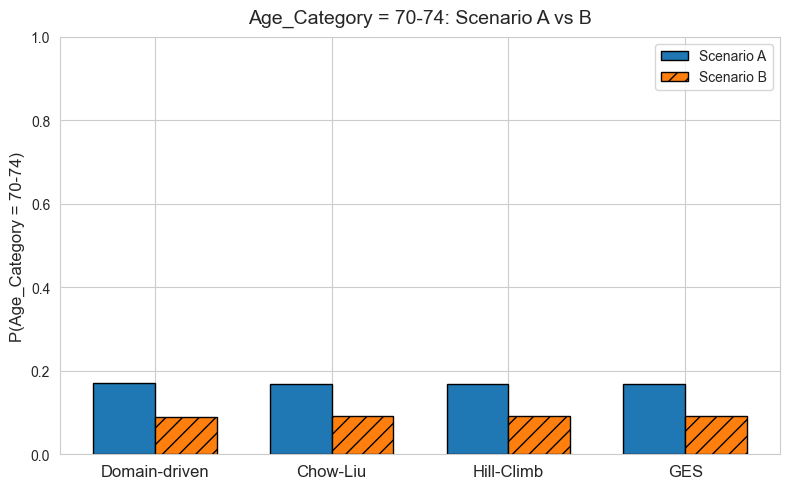

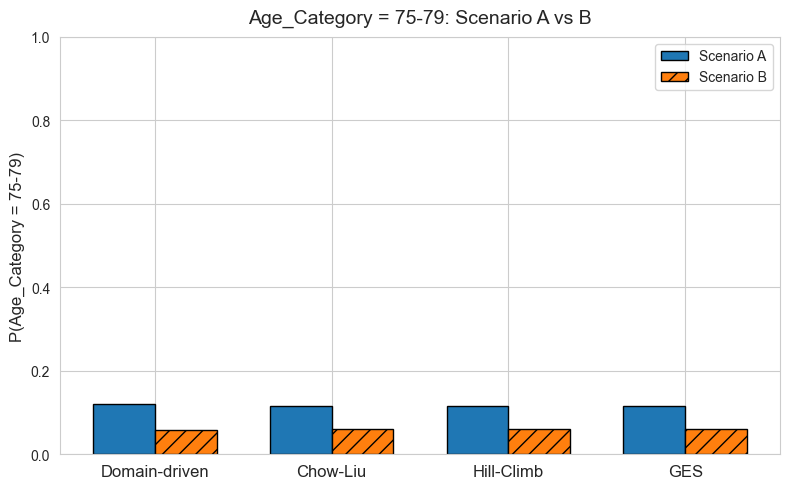

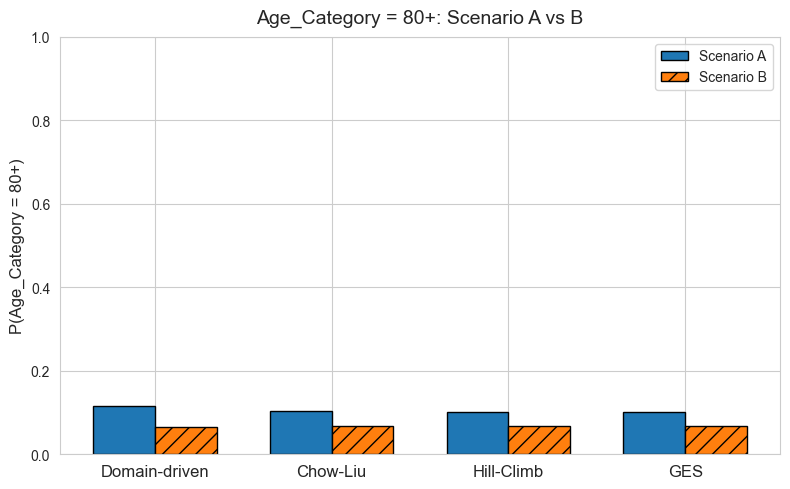

In [97]:
query_func_all_states("Age_Category", {"Diabetes": "Yes"}, {"Diabetes": "No"})

- in this experiment we flipped the usual setup using diabetes status (Yes/No) as evidence and age group as the target to see how the model distributes likely ages when a person’s diabetic status is known.

- The curve is clearly monotonic: diabetes probability rises almost linearly from the young groups to the older ones.

- The gap between adjacent classes becomes steeper after age 45, hinting at a possible biological or lifestyle “turning point.”